In [81]:
import matplotlib.pyplot as plt
import numpy as np  

In [3]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, GPT2LMHeadModel

/Users/inar/.local/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

### Get unembedding matrix and its pseudo-inverse

In [14]:
#Where is it documented?
# Check if works for all models 
unembed = model.get_output_embeddings().weight.detach()

In [62]:
vocab_size, hidden_dim = unembed.shape
vocab_size, hidden_dim

(50257, 768)

In [22]:
# cross check
inputs = tokenizer("This is a test", return_tensors="pt")
outputs = model(**inputs, labels=inputs["input_ids"], output_hidden_states=True)

test_logits = outputs.logits.detach()
explicit_logits = outputs.hidden_states[-1] @ unembed.T

assert torch.allclose(test_logits, explicit_logits)

In [25]:
Wai = unembed.numpy()
pinvWai = np.linalg.pinv(Wai) 

### Iso-Logit vector

This vector is mapped into $\ell_i = 1$. If added to any logit, it doesn't change the probability distribution

$$ p_i = \exp(\ell_i - F), \; F = - \log(Z) $$

Any constant shift $\ell_i \to \ell_i +C$ is abosrbed in F and doesn't change the probability distribution.



In [42]:
iso_vec = pinvWai @ np.ones(50257)

In [52]:
iso_tensor = torch.tensor(iso_vec, dtype=torch.float32)

In [97]:
iso_logits = torch.tensor(eq_vec, dtype=torch.float) @ unembed.T
iso_p = F.softmax(eq_logits, dim=-1)

iso_p.sum(), iso_p.max()*vocab_size, iso_p.min()*vocab_size

(tensor(1.0000), tensor(1.0239), tensor(0.9913))

In [118]:
(vocab_size*iso_p.numpy()).mean(), (vocab_size*iso_p.numpy()).std()

(0.9999995, 0.0012492756)

In [101]:
topk_iso_comp = torch.topk(iso_tensor.abs(),3)
topk_iso_comp

torch.return_types.topk(
values=tensor([2.2210, 0.9253, 0.8440]),
indices=tensor([496,  36, 430]))

In [102]:
iso_candidates = []
for i, v in zip(topk_iso_comp.indices, topk_iso_comp.values):
    if v > 0.5:
        iso_candidate = torch.zeros(hidden_dim)
        iso_candidate[i] = 1.0
        iso_candidates.append(iso_candidate)

In [114]:
for candidate in iso_candidates:
    candidate_logits = candidate @ unembed.T
    candidate_p = F.softmax(candidate_logits, dim=-1)
    print(candidate_p.max()*vocab_size, candidate_p.std()*vocab_size)

tensor(1.0063) tensor(0.0008)
tensor(1.0252) tensor(0.0018)
tensor(1.0249) tensor(0.0013)


In [104]:
test_logits.shape

torch.Size([1, 4, 50257])

In [105]:
for logits in test_logits[0]:
    ptt = F.softmax(logits, dim=-1)
    print(ptt.max()*vocab_size)

tensor(2305.8027)
tensor(7934.9365)
tensor(2678.9431)
tensor(12669.1074)


In [112]:
max_ps = []
ps_std = []
for i in range(hidden_dim):
    candidate = torch.zeros(hidden_dim)
    candidate[i] = 1.0
    candidate_logits = candidate @ unembed.T
    candidate_p = F.softmax(candidate_logits, dim=-1)
    max_ps.append(candidate_p.max())
    ps_std.append(candidate_p.std())

    

In [115]:
max_ps = np.array(max_ps)*vocab_size
ps_std = np.array(ps_std)*vocab_size

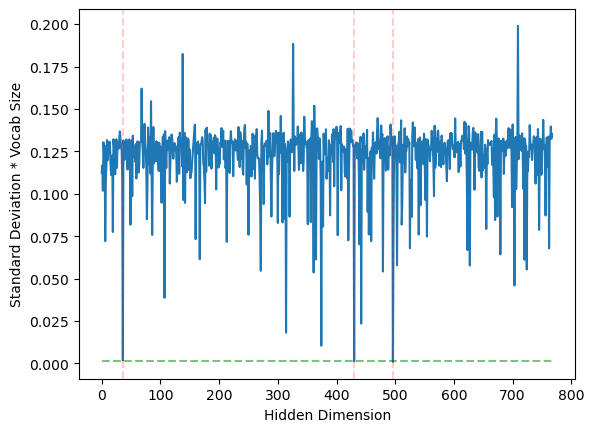

In [125]:
plt.plot(ps_std)
# add hline at iso_p.std()*vocab_size
for i in topk_iso_comp.indices:
    plt.axvline(i, color='r', linestyle='--', alpha=0.2, label = 'iso candidates')
plt.hlines(iso_p.std()*vocab_size, 0, hidden_dim, color='g', linestyle='--', alpha=0.5)
plt.xlabel('Hidden Dimension')
plt.ylabel('Standard Deviation * Vocab Size')

plt.show()

Text(0, 0.5, 'max probability*vocab_size')

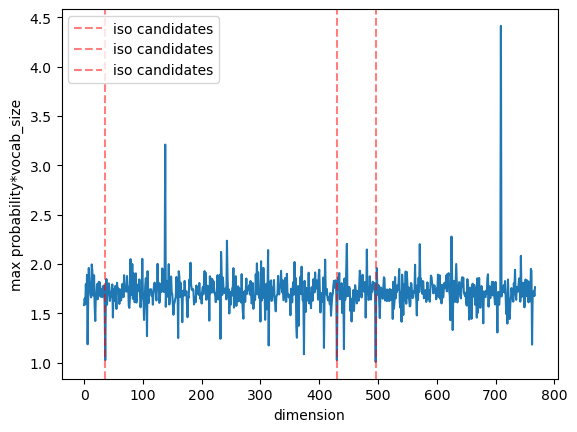

In [111]:
plt.plot(max_ps)
# add vertical lines at topk_iso_comp.indices
for i in topk_iso_comp.indices:
    plt.axvline(i, color='r', linestyle='--', alpha=0.5, label = 'iso candidates')
plt.legend()
plt.xlabel('dimension')
plt.ylabel('max probability*vocab_size')